In [2]:
#networkit
from networkit import *

#numpy scipy
import numpy as np
from scipy.interpolate import interp1d
from scipy.spatial import distance
from scipy.stats import kendalltau

#python stuff
import sqlite3
import glob
import re
from functools import reduce

#matplotlib stuff
from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
from mpl_toolkits.mplot3d import Axes3D

#pandas stuff
import pandas as pd

#inline plots
%matplotlib inline

In [3]:
kitColors = {
    'kitgreen' : (0, 150/255, 130/255),
    'darkkitgreen' : (0, 85/255, 73/255),
    'kitblue' : (70/255, 100/255, 170/255),
    'darkkitblue' : (23/255, 33/255, 85/255),
    'kitmaygreen' : (140/255, 182/255, 60/255),
    'darkkitmaygreen' : (65/255, 85/255, 28/255),
    'kityellow' : (252/255, 229/255, 0),
    'darkkityellow' : (207/255, 188/255, 0),
    'kitorange' : (223/255, 155/255, 27/255),
    'kitbrown' : (167/255, 130/255, 46/255),
    'kitred' : (162/255, 34/255, 35/255),
    'lightkitred': (245/255, 91/255, 92/255),
    'kitpurple' : (163/255, 16/255, 124/255),
    'darkkitpurple' : (85/255, 8/255, 66/255),
    'kitcyanblue' : (35/255, 161/255, 224/255),
    'darkkitcyanblue' : (13/255, 61/255, 85/255),
    'kitgray': (77/255, 77/255, 77/255)
}

#per algorithm
colors_a = {
    'Original':'k', 
    'Local Similarity':'g', 
    'Random':'r', 
    'Simmelian NonParametric':'c',
    'Simmelian Parametric':'m', 
    'Multiscale':'y',
    'Simmelian Multiscale':kitColors['kitorange'], 
    'Degree Multiscale max':kitColors['kitgray'],
    'Degree Multiscale avg':kitColors['darkkitcyanblue'],
    'Degree Multiscale min':kitColors['kitred'],
    'TopDegree':'b', 
    'ForestFire':kitColors['kitred'],
    'Local Degree':'b'
}

# per graph
colors_g = {
    "fb-Tennessee95":'k', 
    "USAviation":'g', 
    "LFR-1000":'r', 
    "BTER":'c', 
    "fb-Caltech36":'m', 
    "KitEmail":'y', 
    "fb-Yale4":kitColors['kitorange'], 
    "Karate":'b', 
    "Jazz":'b',
    "PGP":kitColors['kitred'],
    "fb-Virginia63":kitColors['kitgray']
}

In [4]:
df = pd.read_csv("/home/gerd/workspace/NetworKit-glindner/scripts/SparsificationEvaluation/output/backbones_paper_rc3_pandas.csv")

OSError: File b'/home/gerd/workspace/NetworKit-glindner/scripts/SparsificationEvaluation/output/backbones_paper_rc3_pandas.csv' does not exist

###### Dataset

In [4]:
dsGraphs = ["LFR-1000","KitEmail","USAviation","Karate","PGP","Jazz","BTER","ErdosRenyi","test.fiber.small","AS","HepTh","HepPh","Epinions","fb-Caltech36","fb-Yale4","fb-Virginia63","fb-Tennessee95","fb-FSU53","fb-Michigan23","fb-Indiana69","fb-MSU24","fb-Texas80","fb-UF21","fb-UIllinois20","fb-UGA50"]
dsAlgorithms = ['Original', 'Local Similarity', 'Random', 'Simmelian Parametric', 'Local Degree', 'ForestFire']

###### Utility functions

In [5]:
df[(df.graph=='fb-Caltech36') & (df.algorithm=='Local Similarity')]["numCommunitiesSim"]

4970    0.000007
4971    0.000007
4972    0.000529
4973    0.071621
4974    0.123575
4975    0.177769
4976    0.194687
4977    0.255729
4978    0.280067
4979    0.280067
4980    0.306721
4981    0.306721
4982    0.306721
4983    0.367879
Name: numCommunitiesSim, dtype: float64

In [6]:
def getOriginalValue(df, prop, graph):
    return float(df[(df.graph==graph) & (df.algorithm=='Original')][prop])

In [7]:
def plotOriginalValue(df, ax, prop, graph, showOriginalValue):
    if showOriginalValue == 'hidden':
        return
    elif showOriginalValue == 'hline':
        originalValue = getOriginalValue(df, prop, graph)
        ax.plot([0.0,1.0],[originalValue, originalValue], label='Original', marker='x', color=colors_a['Original'])

In [39]:
def plotPropertyForOneGraph(df, prop, graph, algorithms, showOriginalValue='hline', ylabel=None, title=''):
    fig, ax = plt.subplots(figsize=(6,4))

    plotOriginalValue(df, ax, prop, graph, showOriginalValue)
    
    #plt.yscale('log')
    
    for algorithm in list((set(algorithms) - {'Original'})):
        filtered = df[(df.graph==graph) & (df.algorithm==algorithm)].sort('edgeRatio')
        ax.plot(filtered['edgeRatio'], filtered[prop], label=algorithm, marker='o', color=colors_a[algorithm])
        
    plt.legend(loc='best')
    
    plt.title(title)
    plt.xlabel("sample size")
    plt.ylabel(prop if ylabel is None else ylabel)
    plt.show()

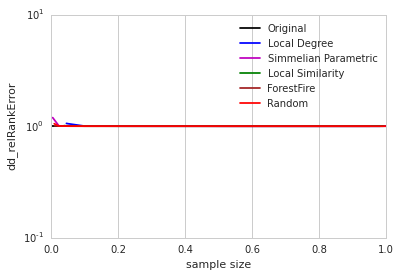

In [29]:
plotPropertyForOneGraph(df, 'dd_relRankError', 'fb-Caltech36', dsAlgorithms, showOriginalValue='hline')

###### Plots...

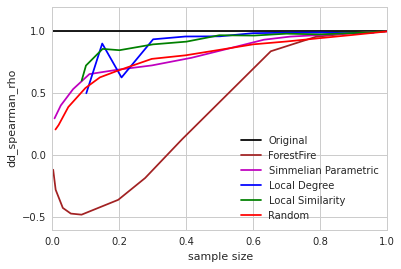

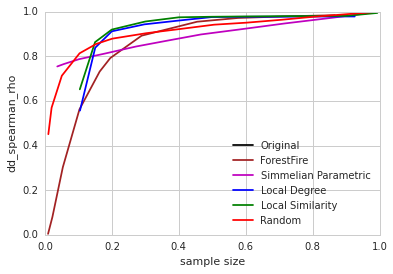

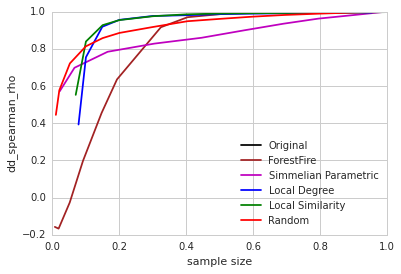

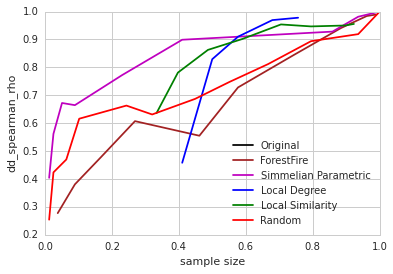

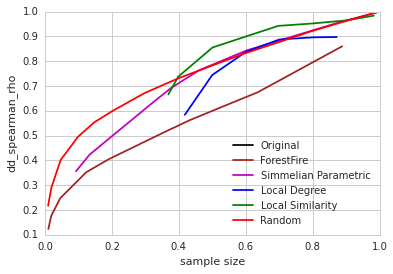

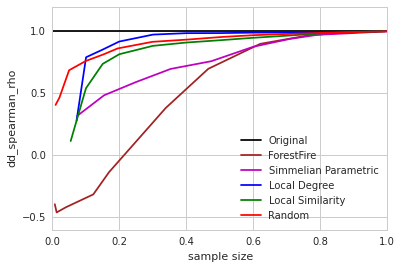

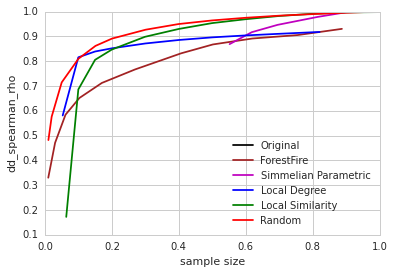

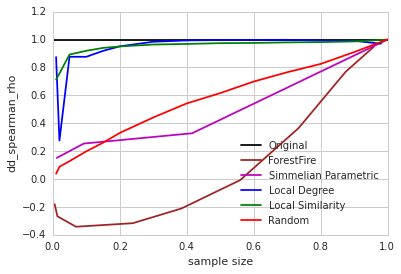

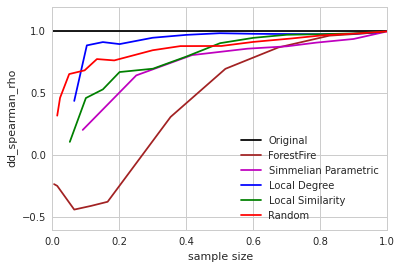

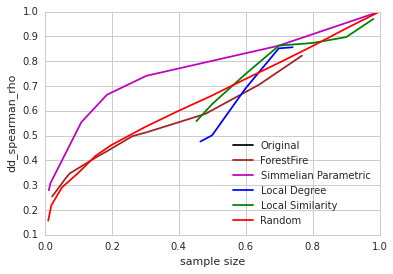

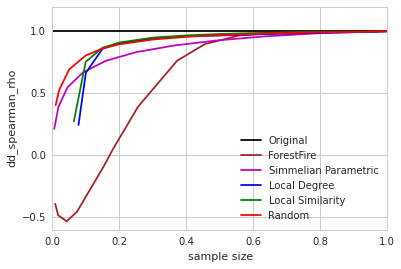

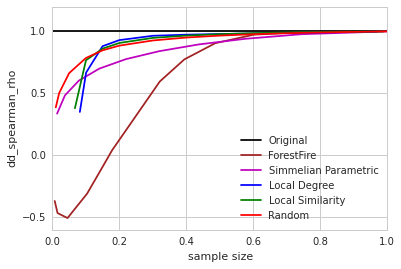

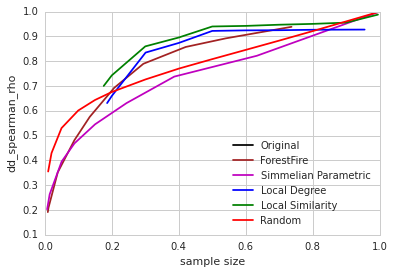

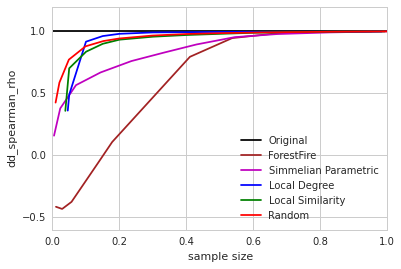

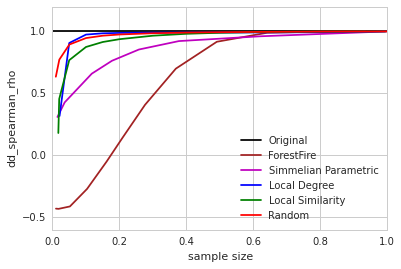

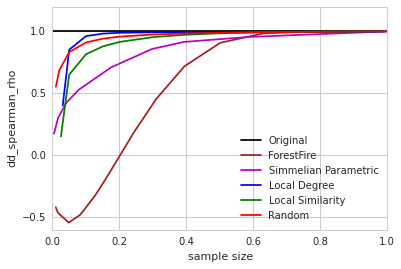

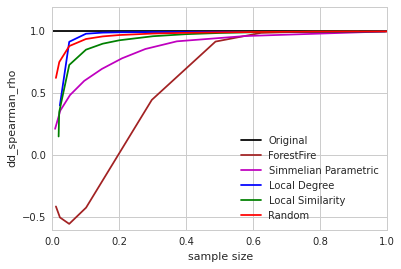

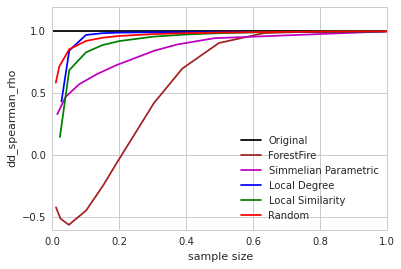

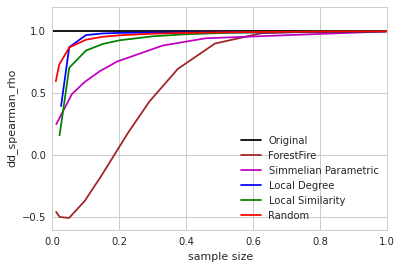

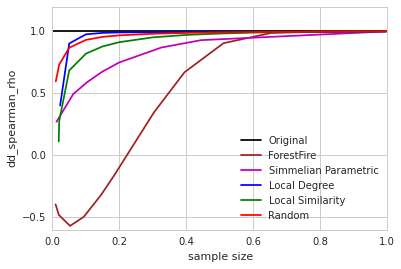

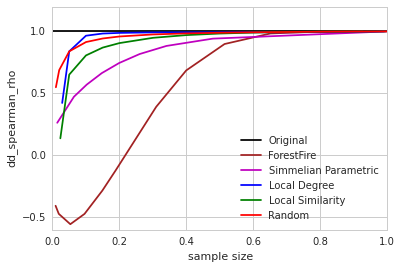

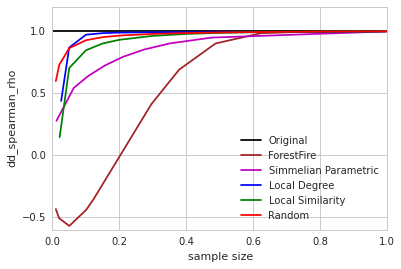

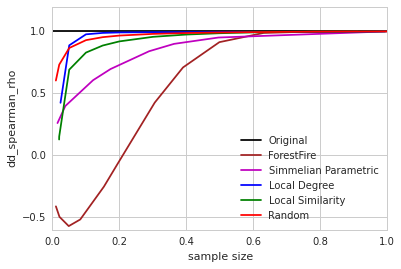

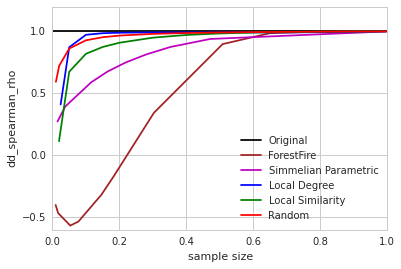

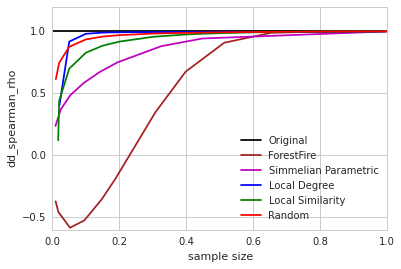

In [10]:
for graph in dsGraphs:
    plotPropertyForOneGraph(df, 'dd_spearman_rho', graph, dsAlgorithms)

###### Average values

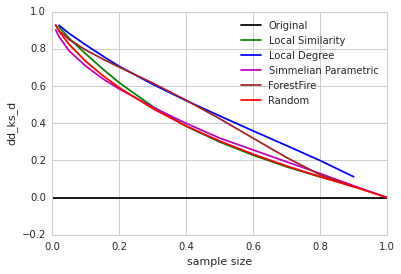

In [8]:
plotPropertyForOneGraph(df, 'dd_ks_d', 'all', dsAlgorithms, showOriginalValue='hline')

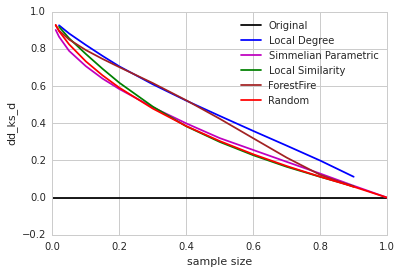

In [10]:
plotPropertyForOneGraph(df, 'dd_ks_d', 'all', dsAlgorithms, showOriginalValue='hline')

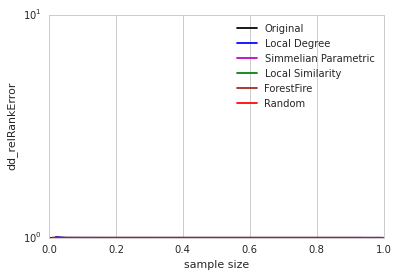

In [10]:
averageableProperties = [
#community
"randMeasure", "nmi", "ccAvgLocal", "modularity",
#degree distribution
"dd_spearman_rho", "dd_ks_d",
#clustering coefficient
"ccGlobal", "ccAvgLocal", "cc_ks_d", "cc_perDegree_ks_d", "cc_spearman_rho", "cc_normalizedAbsDiff",
#weakly connected components
"wcc_nmi", "wcc_sizes_ks",
#pagerank
"pagerank_spearman_rho"]

In [11]:
#for prop in averageableProperties:
#    plotPropertyForOneGraph(df, prop, 'all', dsAlgorithms, showOriginalValue='hline')

###### Paper plots

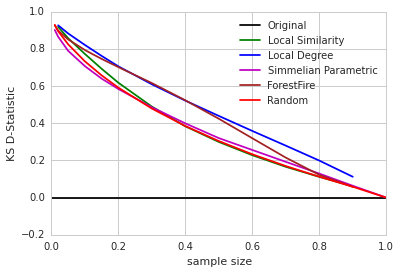

In [12]:
plotPropertyForOneGraph(df, 'dd_ks_d', 'all', dsAlgorithms, showOriginalValue='hline', ylabel='KS D-Statistic')

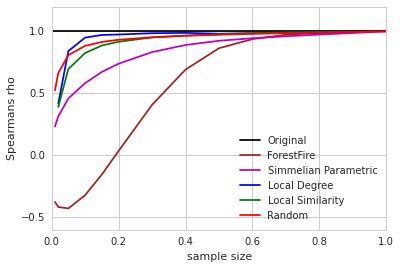

In [15]:
plotPropertyForOneGraph(df, 'dd_spearman_rho', 'all', dsAlgorithms, showOriginalValue='hline', ylabel='Spearmans rho')

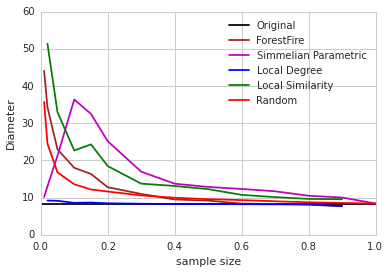

In [16]:
plotPropertyForOneGraph(df, 'diameter', 'all', dsAlgorithms, showOriginalValue='hline', ylabel='Diameter')

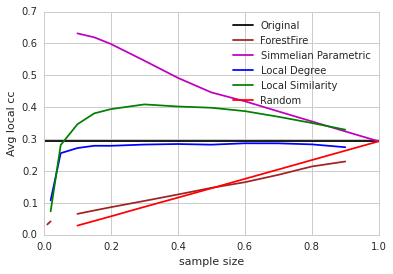

In [17]:
plotPropertyForOneGraph(df, 'ccAvgLocal', 'all', dsAlgorithms, showOriginalValue='hline', ylabel='Avg local cc')

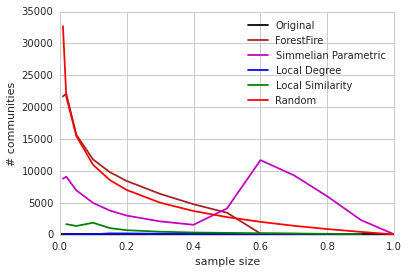

In [18]:
plotPropertyForOneGraph(df, 'numCommunities', 'all', dsAlgorithms, showOriginalValue='hline', ylabel='# communities')

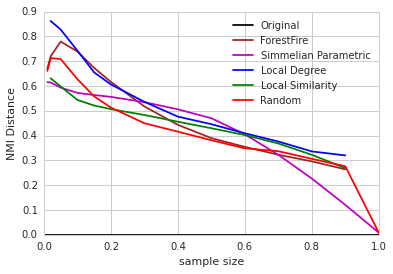

In [19]:
plotPropertyForOneGraph(df, 'nmi', 'all', dsAlgorithms, showOriginalValue='hline', ylabel='NMI Distance')

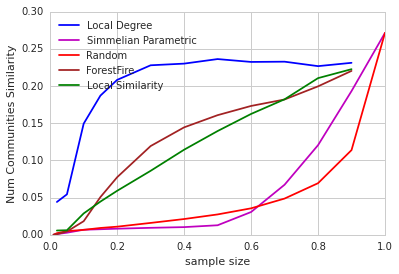

In [29]:
plotPropertyForOneGraph(df, 'numCommunitiesSim', 'all', dsAlgorithms, showOriginalValue='hidden', ylabel='Num Communities Similarity')

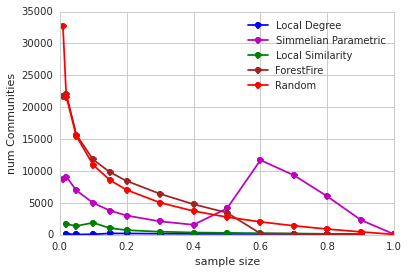

In [42]:
plotPropertyForOneGraph(df, 'numCommunities', 'all', dsAlgorithms, showOriginalValue='hidden', ylabel='num Communities')

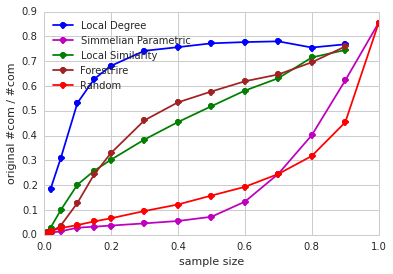

In [41]:
plotPropertyForOneGraph(df, 'numCommunitiesSim', 'all', dsAlgorithms, showOriginalValue='hidden', ylabel='original #com / #com')

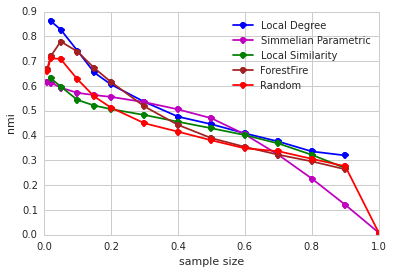

In [40]:
plotPropertyForOneGraph(df, 'nmi', 'all', dsAlgorithms, showOriginalValue='hidden', ylabel='nmi')